In [112]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split as splitter
import cProfile
import pstats
import os
import sys
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

print("Librerie importate con successo")

Librerie importate con successo


In [113]:
data = pd.read_csv('../Datasets/kdd_prediction.csv', delimiter=',',
                       dtype={'protocol_type': str, 'service': str, 'flag': str, 'result': str})
#print("Dataset : \n")
#print(data.head()) #Stampa per visualizzare il dataset
print(data.shape)

(13451, 22)


Total :  13451
Normal :  7500
Malicious :  5951


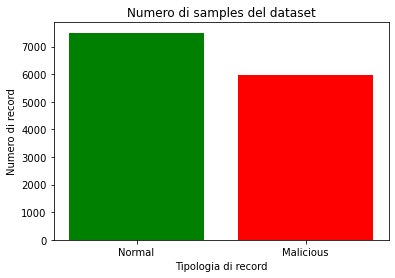

In [114]:
total_flows_count = data["result"].count()
normal_flows_count = len(data[data.result == "normal"])
anomaly_flows_count = len(data[data.result != "normal"])

print("Total : ",total_flows_count)
print("Normal : ",normal_flows_count)
print("Malicious : ",anomaly_flows_count)

# x-coordinates of left sides of bars  
left = [1, 1.5] 
  
# heights of bars 
height = [normal_flows_count, anomaly_flows_count] 
  
# labels for bars 
tick_label = ['Normal', 'Malicious'] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['green', 'red']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di record') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Numero di samples del dataset') 
  
plt.show() 

In [115]:
def preprocessing(data):
    for column in data.columns:
        if data[column].dtype == type(object):
            le = LabelEncoder()
            data[column] = le.fit_transform(data[column])

In [116]:

data_train = data[data.result == "normal"] #prendo solo i valori "normali" per il train
data_val = data.copy()


preprocessing(data_train)
preprocessing(data_val)
        
x_train = data_train.drop('result',axis=1) #rimuove la colonna result dal dataframe
data_val = data_val.drop('result', axis=1) #per la validation mi servono tutti i record, anche quelli malevoli

#valori per la validation
data_val = data_val.sample(frac=1, random_state=7492).reset_index(drop=True) #randomizza le righe del dataframe resettando gli indici
percentage = 25
x_val = data_val.head(int(len(data_val)*(percentage/100))) #prendo il 25% del dataset per la validation

print("x_train dataframe shape: ", x_train.shape)
print("x_val dataframe shape: ", x_val.shape)

x_train dataframe shape:  (7500, 21)
x_val dataframe shape:  (3362, 21)


<ipython-input-115-14dd7e54de29>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = le.fit_transform(data[column])


In [117]:
arr_train = x_train.to_numpy() #conversione da dataframe ad array numpy
arr_train = arr_train.reshape(arr_train.shape[0],arr_train.shape[1],1) #converte la shape da 2d a 3d per layer LSTM
print("Training input shape: ", arr_train.shape)

arr_val = x_val.to_numpy()
arr_val = arr_val.reshape(arr_val.shape[0],arr_val.shape[1],1)
print("Validation input shape: ", arr_val.shape)


Training input shape:  (7500, 21, 1)
Validation input shape:  (3362, 21, 1)


In [118]:
model = keras.Sequential(
    [
       layers.Input(shape=(arr_train.shape[1], arr_train.shape[2])),
       layers.LSTM(16, activation='relu', return_sequences=True), 
       layers.LSTM(8, activation='relu', return_sequences=False),
        
       layers.RepeatVector(arr_train.shape[1]), 
        
        
       layers.LSTM(8, activation='relu', return_sequences=True),
       layers.LSTM(16, activation='relu', return_sequences=True),
       layers.TimeDistributed(layers.Dense(1))    
    ]
)
model.compile( optimizer='adam', loss='mse')
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 21, 16)            1152      
_________________________________________________________________
lstm_49 (LSTM)               (None, 8)                 800       
_________________________________________________________________
repeat_vector_14 (RepeatVect (None, 21, 8)             0         
_________________________________________________________________
lstm_50 (LSTM)               (None, 21, 8)             544       
_________________________________________________________________
lstm_51 (LSTM)               (None, 21, 16)            1600      
_________________________________________________________________
time_distributed_14 (TimeDis (None, 21, 1)             17        
Total params: 4,113
Trainable params: 4,113
Non-trainable params: 0
___________________________________________________

In [119]:
history = model.fit(
    arr_train,
    arr_train,
    epochs=50,
    batch_size=150,
    validation_data=(arr_val, arr_val),
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, mode="min")
    ],
)

Epoch 1/50
50/50 [==============================] - 3s 63ms/step - loss: 4.9833 - val_loss: 51.8352
Epoch 2/50
50/50 [==============================] - 2s 42ms/step - loss: 3.2120 - val_loss: 53.0706
Epoch 3/50
50/50 [==============================] - 2s 40ms/step - loss: 1.3670 - val_loss: 52.0280
Epoch 4/50
50/50 [==============================] - 3s 65ms/step - loss: 0.8146 - val_loss: 51.1179
Epoch 5/50
50/50 [==============================] - 2s 40ms/step - loss: 0.7825 - val_loss: 51.0647
Epoch 6/50
50/50 [==============================] - 2s 43ms/step - loss: 0.7282 - val_loss: 50.1612
Epoch 7/50
50/50 [==============================] - 2s 43ms/step - loss: 3.5773 - val_loss: 51.5856
Epoch 8/50
50/50 [==============================] - 2s 44ms/step - loss: 3.8756 - val_loss: 50.8037
Epoch 9/50
50/50 [==============================] - 2s 43ms/step - loss: 1.1579 - val_loss: 51.9751
Epoch 10/50
50/50 [==============================] - 2s 43ms/step - loss: 0.9539 - val_loss: 52.9598

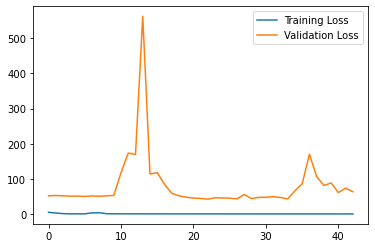

In [120]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

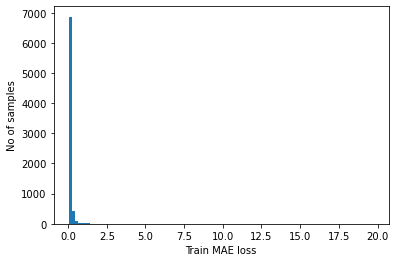

Reconstruction error threshold:  1.9401718137940702


In [121]:
x_train_pred = model.predict(arr_train)
train_mae_loss = np.mean(np.abs(x_train_pred - arr_train), axis=1)
train_mae_loss = train_mae_loss.ravel() #converte l'array numpy in 1d
train_mae_loss = np.sort(train_mae_loss) #quicksort


train_mae_loss_len = len(train_mae_loss)
n_index = int(0.999*train_mae_loss_len)
plt.hist(train_mae_loss, bins=100)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
train_mae_loss_split = train_mae_loss[:n_index]
threshold = np.max(train_mae_loss_split)
print("Reconstruction error threshold: ", threshold)

In [122]:
#data_test

data_test = data.copy()

data_test = data_test.sample(frac=1, random_state=3839).reset_index(drop=True) #randomizza le righe del dataframe resettando gli indici
percentage = 30
data_test_splitted = data_test.head(int(len(data_test)*(percentage/100))) #prendo il 30% del dataset completo per il test

print("data_test_splitted dataframe shape: ", data_test_splitted.shape)

data_test_splitted dataframe shape:  (4035, 22)


Total :  4035
Normal :  2285
Malicious :  1750


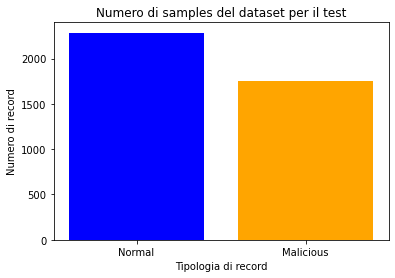

x_test shape : (4035, 21)


<ipython-input-115-14dd7e54de29>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = le.fit_transform(data[column])


In [123]:
total_flows_count_test = data_test_splitted["result"].count()
normal_flows_count_test = len(data_test_splitted[data_test_splitted.result == "normal"])
anomaly_flows_count_test = len(data_test_splitted[data_test_splitted.result != "normal"])

print("Total : ",total_flows_count_test)
print("Normal : ",normal_flows_count_test)
print("Malicious : ",anomaly_flows_count_test)

# x-coordinates of left sides of bars  
left = [1, 1.5] 
  
# heights of bars 
height = [normal_flows_count_test, anomaly_flows_count_test] 
  
# labels for bars 
tick_label = ['Normal', 'Malicious'] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['blue', 'orange']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di record') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Numero di samples del dataset per il test') 
  
plt.show() 

preprocessing(data_test_splitted)
x_test = data_test_splitted.drop('result',axis=1) #rimuove la colonna result dal dataframe
print("x_test shape :", x_test.shape)

In [124]:
arr_test = x_test.to_numpy() #conversione da dataframe ad array numpy
arr_test = arr_test.reshape(arr_test.shape[0],arr_test.shape[1],1) #converte la shape da 2d a 3d per layer LSTM
print("Training input shape: ", arr_test.shape)

Training input shape:  (4035, 21, 1)


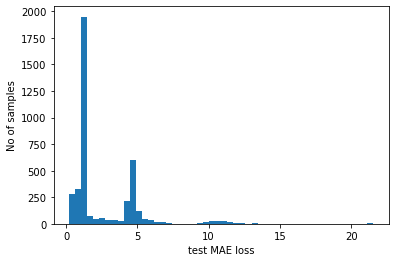

Number of anomaly samples:  1408
Indices of anomaly samples:  (array([   1,    3,    6, ..., 4023, 4032, 4033], dtype=int64),)


In [125]:
arr_test_pred = model.predict(arr_test)
test_mae_loss = np.mean(np.abs(arr_test_pred - arr_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))
                                       
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))                                       